In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## About Dataset

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

<b>Dataset can be found in kaggle [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)</b>

In [2]:
# we are going to study the PJME dataset
plant = "PJME"
data = pd.read_csv(f'./hourly_energy_cons/{plant}_hourly.csv', parse_dates=True, index_col=[0])
data.rename(columns={f"{plant}_MW":'Power_Demand'}, inplace=True)

In [3]:
data.head()

,Power_Demand
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
data.shape

(145366, 1)

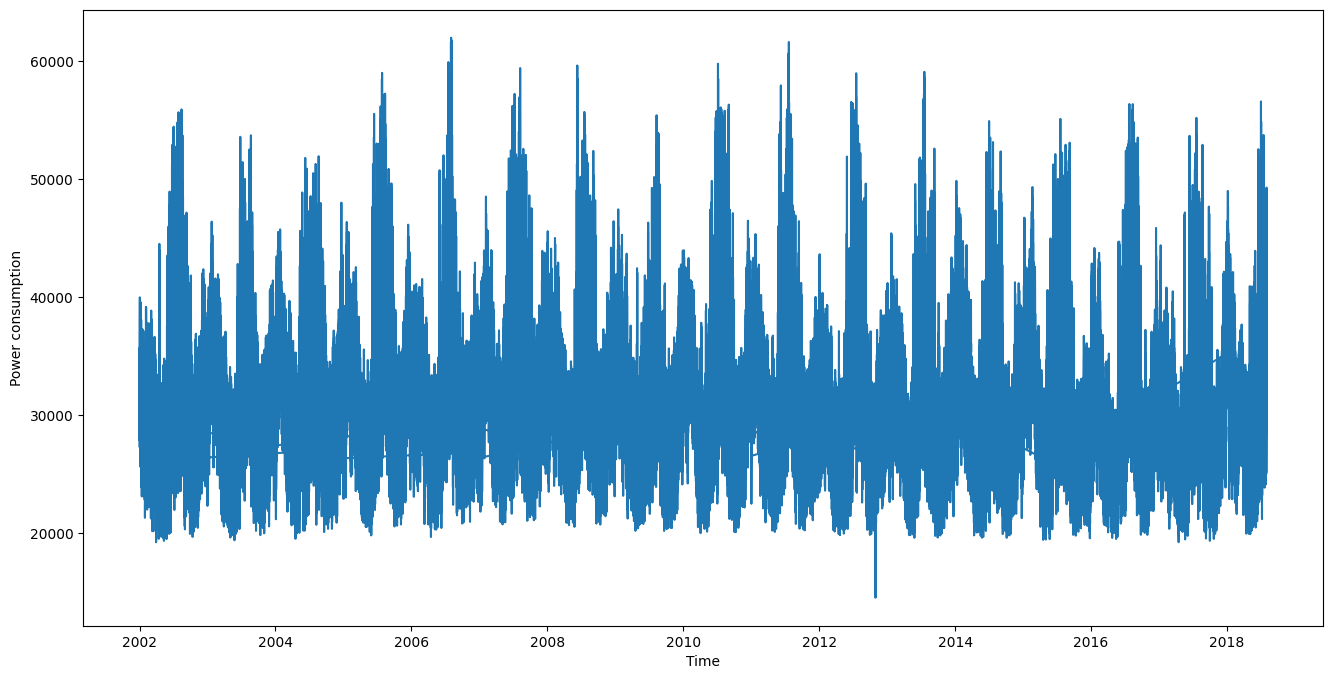

In [5]:
# Visualise the power consumption data
plt.figure(figsize=(16,8))
plt.plot(data["Power_Demand"])
plt.xlabel('Time')
plt.ylabel('Power consumption')
plt.show()

## Data cleaning

Before starting the data analysis, we will first check if the data contains nan values or duplicated datetimes and remove them if they exist.

Because we are dealing with an hourly based dataset we must also ensure that all recorded hours are present in the data, this can be done by checking the data time frequency (which should be in Hours).

In [6]:
# look for null/Nan instances in the data
data.isna().sum()

Power_Demand    0
dtype: int64

In [7]:
# Check for duplicated datetimes (index)
print(f"Duplicate count: {data.index.duplicated().sum()}")
# remove duplicates
data = data[~data.index.duplicated()]

Duplicate count: 4


In [8]:
# Check datetimes frequency
print(f"Data datetime frequency : {data.index.array.freq}")

Data datetime frequency : None


The fact that frequency is None means that there are missing datetimes, we can find those by comparing the original dataset datetimes with an hourly date range created for the same period.

In [9]:
dates = pd.to_datetime(data.index)
date_range = pd.date_range(start=min(dates), end=max(dates), freq='H')
print(f"Missing datetimes:\n{date_range.difference(dates.array)}")

Missing datetimes:
DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)


To handle those missing values, we must reindex the data with the full hourly date range. This will introduce null values to the power demand data, those can be filled using previous/next methods but to keep the continous aspect of the power demand data a linear interpolation is used instead.

In [10]:
data = data.reindex(date_range)
data['Power_Demand'].interpolate(method='linear', inplace=True)

In [11]:
# Check datetimes frequency again
print(f"Data datetime frequency : {data.index.array.freq}")

Data datetime frequency : <Hour>


## Extracting more date/time features

In order to use this data to train ML models (XGB, RF,...), we must first put it in the form of a supervised learning task (features/target). So from the datetimes values we will extract the following features: hour, day of week, quarter, month, year, day of year, day of month , week of year.

In [12]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['dayofmonth'] = data.index.day
data['dayofyear'] = data.index.dayofyear
data['quarter'] = data.index.quarter
data['month'] = data.index.month
data['year'] = data.index.year
data['weekofyear'] = data.index.isocalendar().week.astype("int")

data = data[['hour','dayofweek', 'dayofmonth','dayofyear', 'quarter',
             'month','year', 'weekofyear', "Power_Demand"]]

In [13]:
data.head()

,hour,dayofweek,dayofmonth,dayofyear,quarter,month,year,weekofyear,Power_Demand
2002-01-01 01:00:00,1,1,1,1,1,1,2002,1,30393.0
2002-01-01 02:00:00,2,1,1,1,1,1,2002,1,29265.0
2002-01-01 03:00:00,3,1,1,1,1,1,2002,1,28357.0
2002-01-01 04:00:00,4,1,1,1,1,1,2002,1,27899.0
2002-01-01 05:00:00,5,1,1,1,1,1,2002,1,28057.0


## Exploratory Data Analysis

<Axes: xlabel='month', ylabel='Power_Demand'>

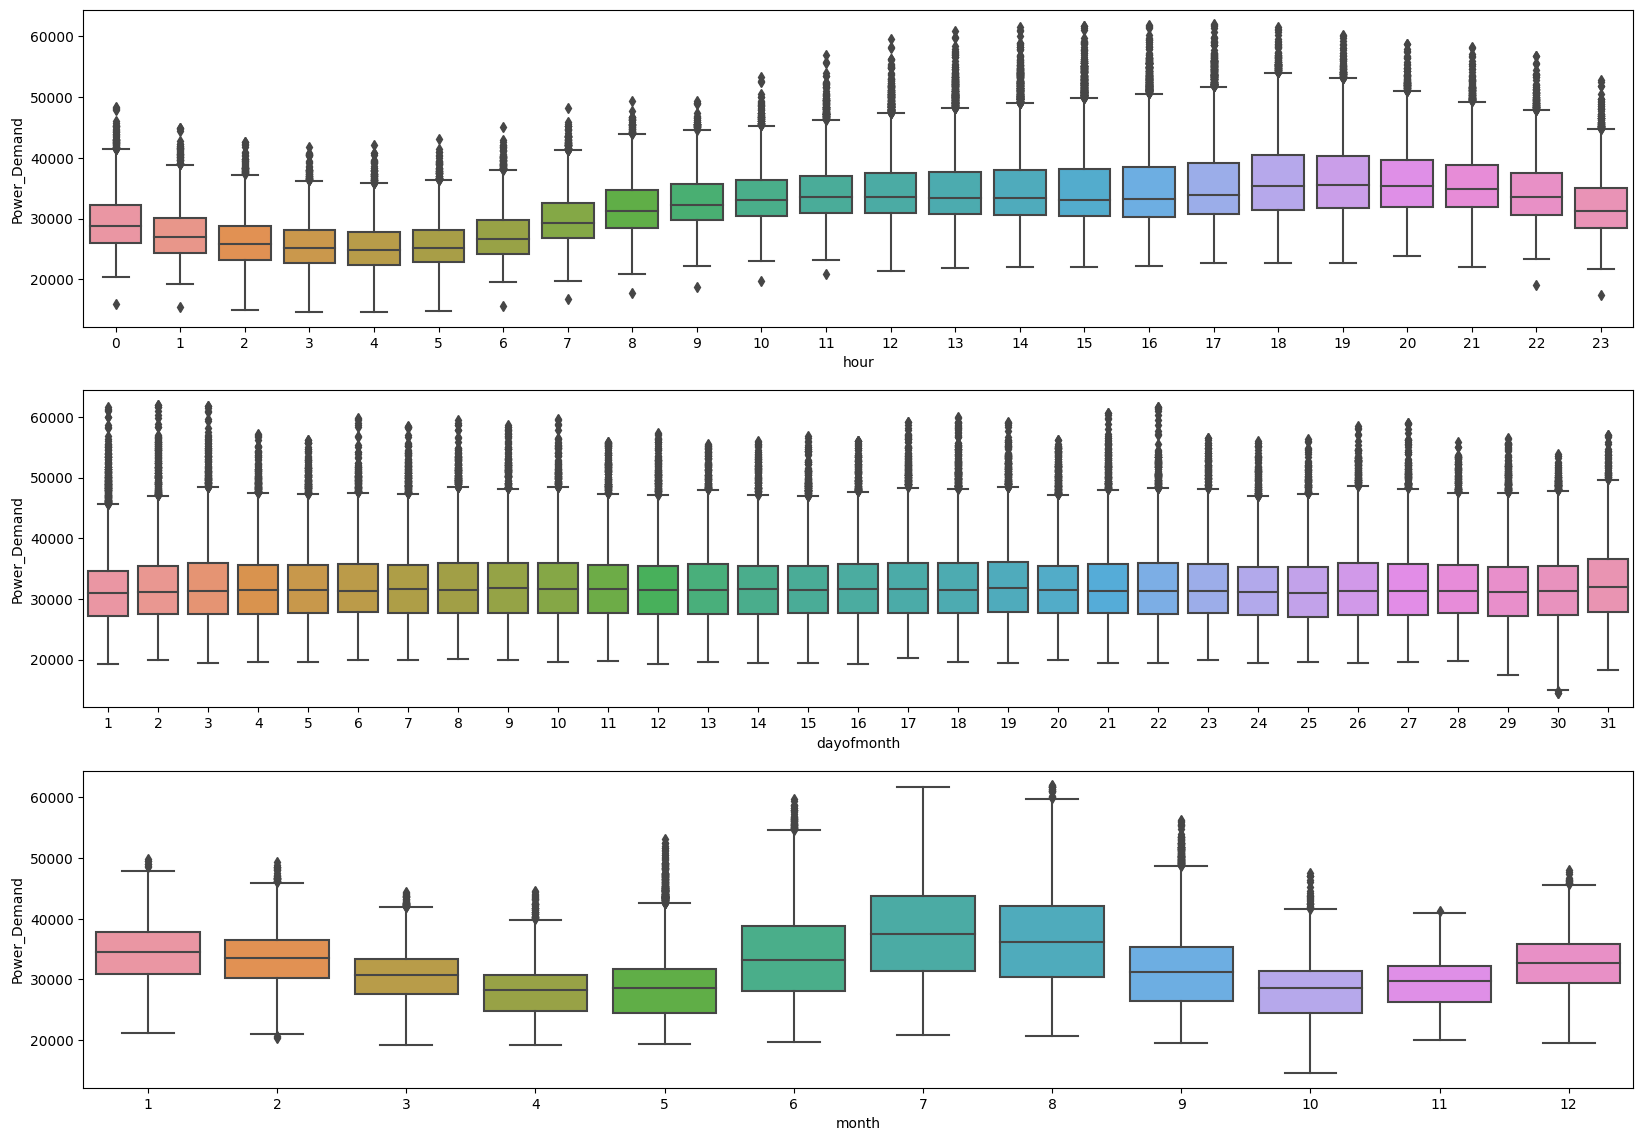

In [14]:
# plot hourly, daily and monthly power consumption
fig, axes = plt.subplots(3, figsize=(20, 14))
sns.boxplot(data, x="hour", y="Power_Demand", ax=axes[0])
sns.boxplot(data, x="dayofmonth", y="Power_Demand", ax=axes[1])
sns.boxplot(data, x="month", y="Power_Demand", ax=axes[2])

#### Observation

* The daily power consumption peak typically occurs between 5:00 PM and 8:00 PM, while the lowest demand is during the late-night hours from 2:00 AM to 5:00 AM. This observation aligns with logical expectations.

* The power consumption is at highest in during the summer months of June, July, and August.

* We notice that the data contain many outlier values that can be observed in all the plots, we will take a closer look at those values before going further into the study.

### Outliers analysis

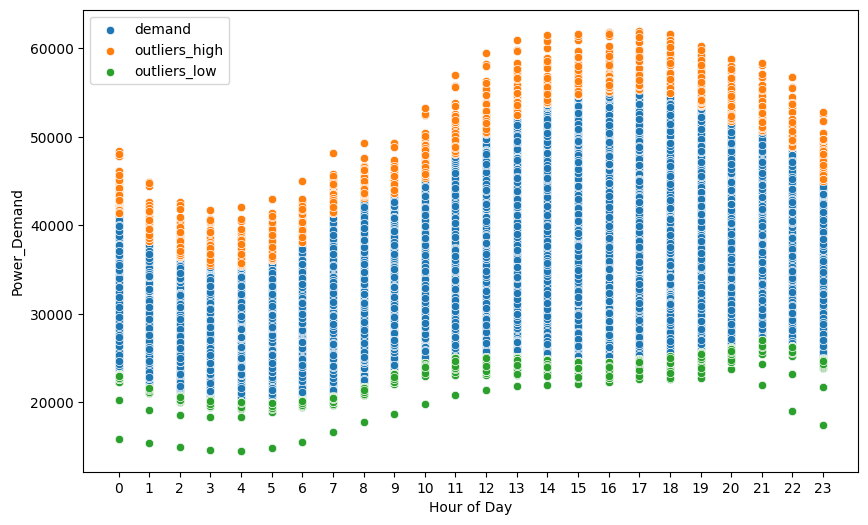

In [15]:
df = data.copy()

# below 1% quantile
df = df.merge(df.groupby('hour')
            .quantile(0.01, numeric_only=True)["Power_Demand"]\
            .rename('OUTLIERS_LOW'),
             on='hour',
             how='left')
# over 99% quantile
df = df.merge(df.groupby('hour')\
            .quantile(0.99, numeric_only=True)["Power_Demand"]\
            .rename('OUTLIERS_HIGH'),
             on='hour',
             how='left')

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df, y="Power_Demand", x='hour')
sns.scatterplot(data=df.query(f'Power_Demand > OUTLIERS_HIGH'), y="Power_Demand", x='hour')
sns.scatterplot(data=df.query(f'Power_Demand < OUTLIERS_LOW'), y="Power_Demand", x='hour')
plt.ylabel("Power_Demand")
plt.xlabel('Hour of Day')
ax.set_xticks([i for i in range(24)])
ax.legend(['demand', 'outliers_high', 'outliers_low'])

In [16]:
# Replace ouyliers with Nan values
outliers = (df["Power_Demand"] < df.OUTLIERS_LOW) | (df["Power_Demand"] > df.OUTLIERS_HIGH)
df["Power_Demand"] = df["Power_Demand"].mask(outliers, np.NAN)

<Axes: xlabel='hour', ylabel='Power_Demand'>

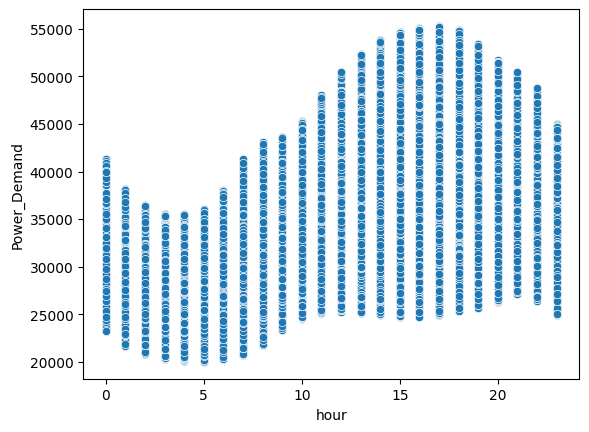

In [17]:
# plot power demand without outliers
sns.scatterplot(data=df, y="Power_Demand", x='hour')

In [18]:
# get the days with most missing values after removing outliers
df[df.Power_Demand.isna()].dayofyear.value_counts().head()

200    70
199    53
214    52
215    48
109    39
Name: dayofyear, dtype: int64

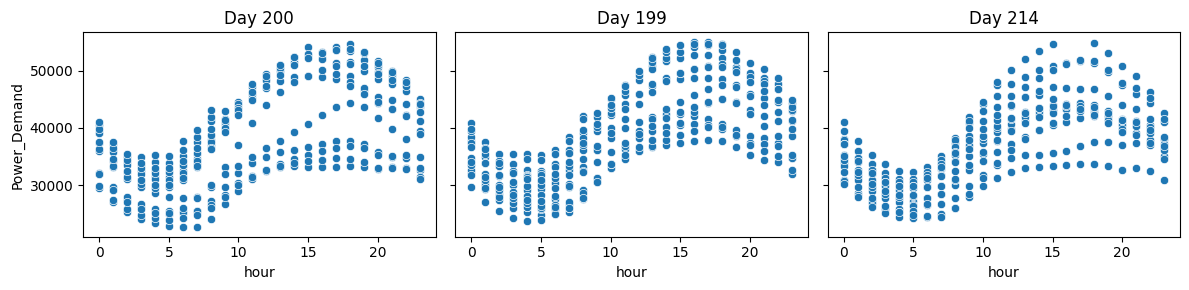

In [19]:
# Plot days with most missing values after removing outliers
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
sns.scatterplot(data=df[(df.dayofyear == 200)], x='hour', y="Power_Demand", ax=axes[0])
sns.scatterplot(data=df[(df.dayofyear == 199)], x='hour', y="Power_Demand", ax=axes[1])
sns.scatterplot(data=df[(df.dayofyear == 214)], x='hour', y="Power_Demand", ax=axes[2])
axes[0].set_title("Day 200")
axes[1].set_title("Day 199")
axes[2].set_title("Day 214")
plt.tight_layout()

#### 1- Imputing with Interpolation

In [20]:
# Try imputing using interpolation
df.index = data.index
df["Imputed_Demand"] = df.Power_Demand.interpolate(method="time")

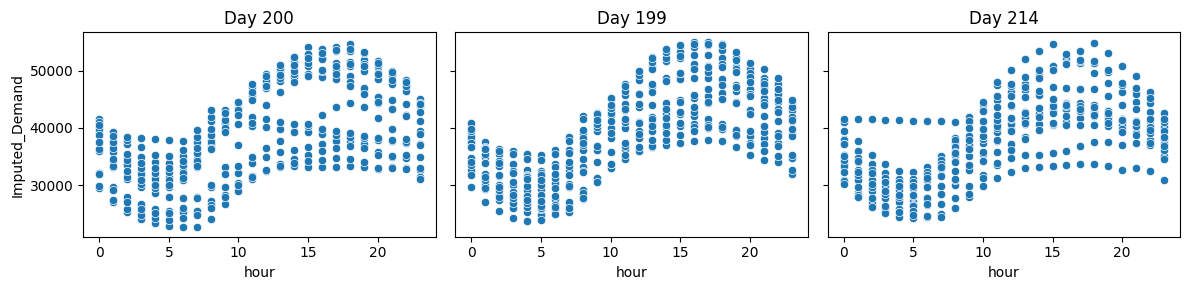

In [21]:
# Plot days with most missing values after removing outliers
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
sns.scatterplot(data=df[(df.dayofyear == 200)], x='hour', y="Imputed_Demand", ax=axes[0])
sns.scatterplot(data=df[(df.dayofyear == 199)], x='hour', y="Imputed_Demand", ax=axes[1])
sns.scatterplot(data=df[(df.dayofyear == 214)], x='hour', y="Imputed_Demand", ax=axes[2])
axes[0].set_title("Day 200")
axes[1].set_title("Day 199")
axes[2].set_title("Day 214")
plt.tight_layout()

#### 2- Imputing with hourly mean values

In [22]:
# calculate mean power demand for each day hour
df = df.merge(df.groupby('hour')
            .mean(numeric_only=True)["Power_Demand"]\
            .rename('Means'),
             on='hour',
             how='left')
df.index = data.index

In [23]:
# use mean values to fill missing data
df["Imputed_Demand"] = df.Power_Demand.fillna(value=df.Means)

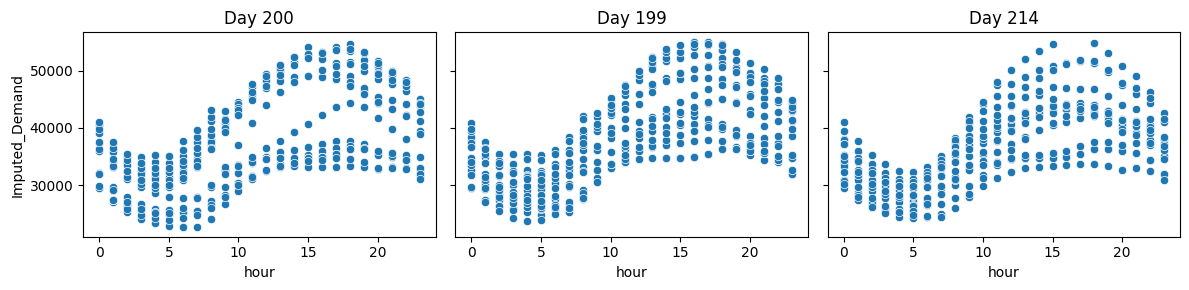

In [24]:
# Plot days with most missing values after removing outliers
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
sns.scatterplot(data=df[(df.dayofyear == 200)], x='hour', y="Imputed_Demand", ax=axes[0])
sns.scatterplot(data=df[(df.dayofyear == 199)], x='hour', y="Imputed_Demand", ax=axes[1])
sns.scatterplot(data=df[(df.dayofyear == 214)], x='hour', y="Imputed_Demand", ax=axes[2])
axes[0].set_title("Day 200")
axes[1].set_title("Day 199")
axes[2].set_title("Day 214")
plt.tight_layout()

#### Observation

* It's clear that using hourly mean power demand values give better results than the interpolation methods as it preserve the smoothness of the data, so will use the mean method to fill the missing values.

In [25]:
# Apply imputation on real data
data["Power_Demand"] = df["Imputed_Demand"]

### Seasonality analysis

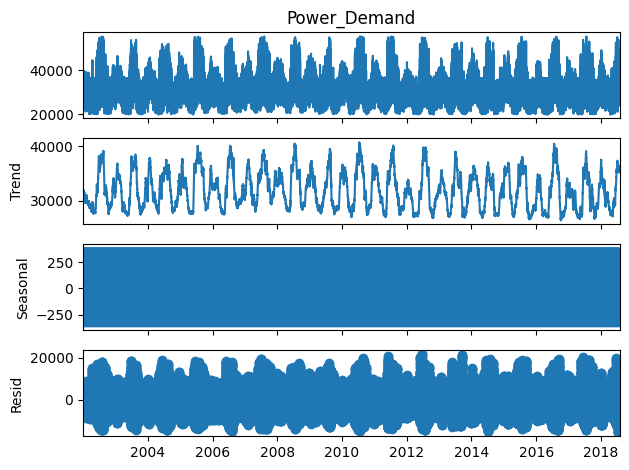

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# visualise the seasonality of the power consumption through the years
seasonal_decompose(data["Power_Demand"], period=365).plot()
plt.show()

#### Observation

The power consumption data has a high seasonality component and the residual shows that it contains a lot of noise through the years.

## Data Preprocessing

Before building the regression models, we will first perform a scaling of the power demand data to facilitate the learning of the models.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
target = scaler.fit_transform(data["Power_Demand"].values.reshape(-1,1))
data["Power_Demand"] = target

In [28]:
def split_data(data, split_date):
    train_data = data.loc[data.index <= split_date]
    test_data = data.loc[data.index > split_date]
    y_train = train_data['Power_Demand']
    x_train = train_data.drop(['Power_Demand'], axis=1)
    y_test = test_data['Power_Demand']
    x_test = test_data.drop(['Power_Demand'], axis=1)
    return x_train, y_train, x_test, y_test

In [29]:
split_date = "2017-06-01 00:00:00"
x_train, y_train, x_test, y_test = split_data(data.copy(), split_date)

<Axes: >

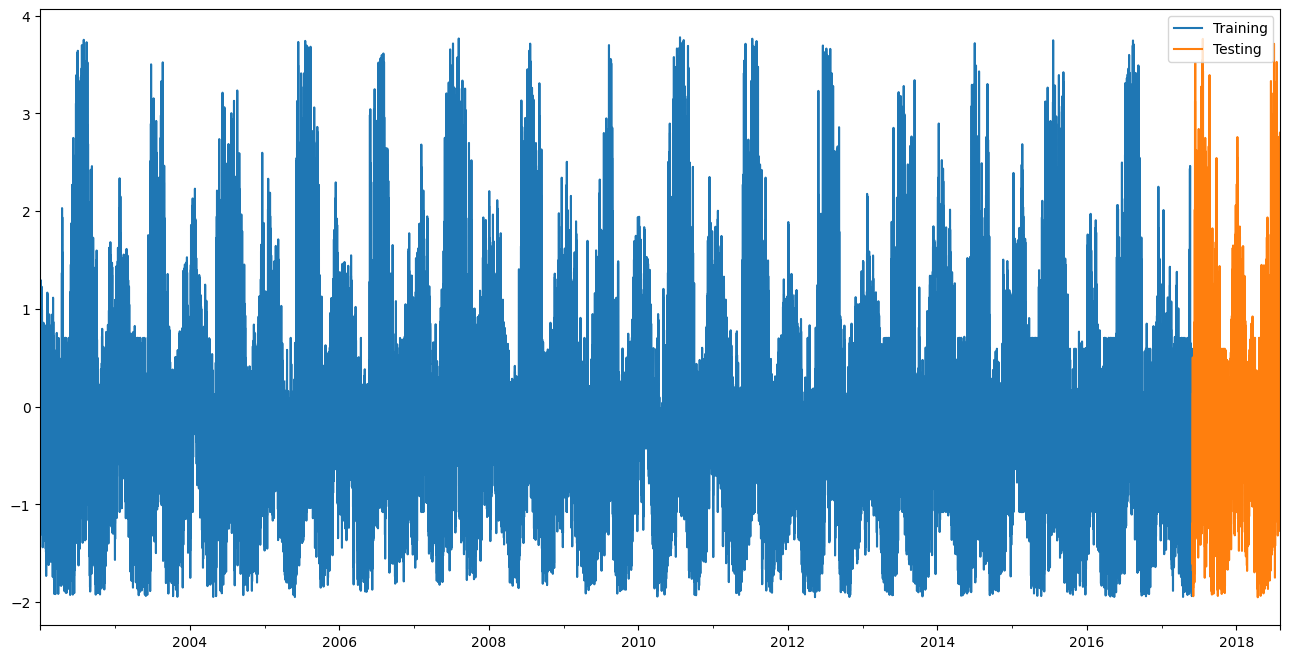

In [30]:
# Plot training and testing date splits
pd.DataFrame(y_train) \
    .rename(columns={'Power_Demand': 'Training'}) \
    .join(pd.DataFrame(y_test).rename(columns={'Power_Demand': 'Testing'}), how='outer') \
    .plot(figsize=(16,8))

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute the accuracy errors : MAE, MSE, RMSE, MAPE, R2 score.
def get_prediction_errors(y_true, y_pred):
    print(f"R2 score: {r2_score(y_true, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16,8))
    plt.plot(test, label='Actual power consumption')
    plt.plot(predicted, alpha=0.7, label='Predicted power consumption')
    plt.xlabel('Time')
    plt.ylabel('Power consumption')
    plt.legend()
    plt.show()

## Building Models

### 1- XGBoost :

In [33]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50, base_score=0.5)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=0)

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

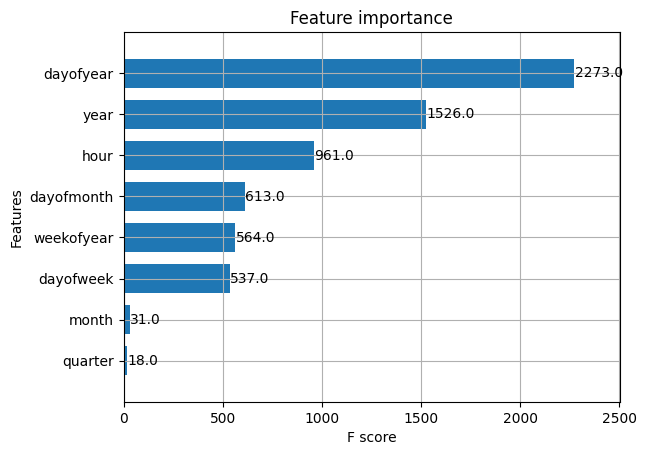

In [34]:
_ = xgb.plot_importance(reg, height=0.7)

In [35]:
test = pd.concat([y_test, pd.Series(reg.predict(x_test), index=y_test.index)], axis=1)
test.columns = ["Power_Demand", "Predicted demand"]

In [36]:
get_prediction_errors(y_true=test["Power_Demand"], y_pred=test["Predicted demand"])

R2 score: 0.6248276515262248
MAE: 0.47581438566660983
MSE: 0.3833132690145165
RMSE: 0.6191229837556642
MAPE: 429.262618533062


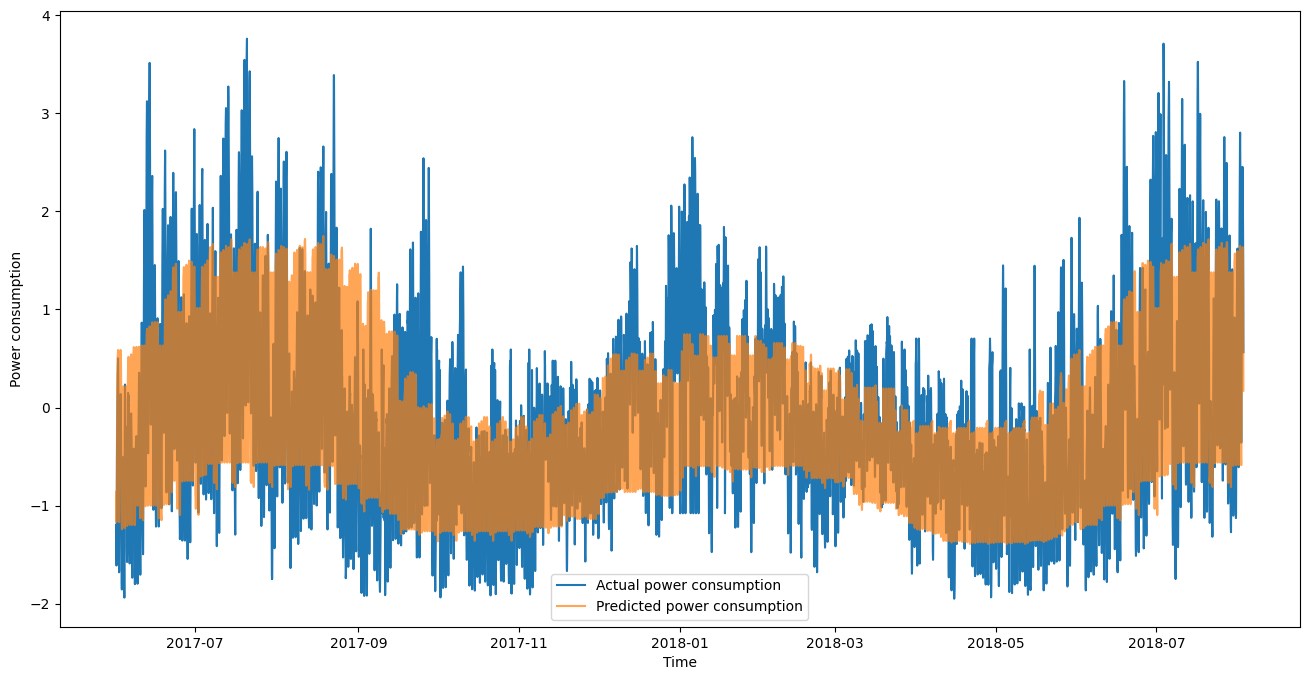

In [37]:
plot_predictions(test["Power_Demand"], test["Predicted demand"])

### 2- Random Forest Regressor :

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200)

In [39]:
test["Predicted demand"] = rf.predict(x_test)
get_prediction_errors(np.array(test["Power_Demand"]), test["Predicted demand"])

R2 score: 0.45288813355811963
MAE: 0.5495340870839366
MSE: 0.558983728133498
RMSE: 0.7476521438031847
MAPE: 572.2290455572564


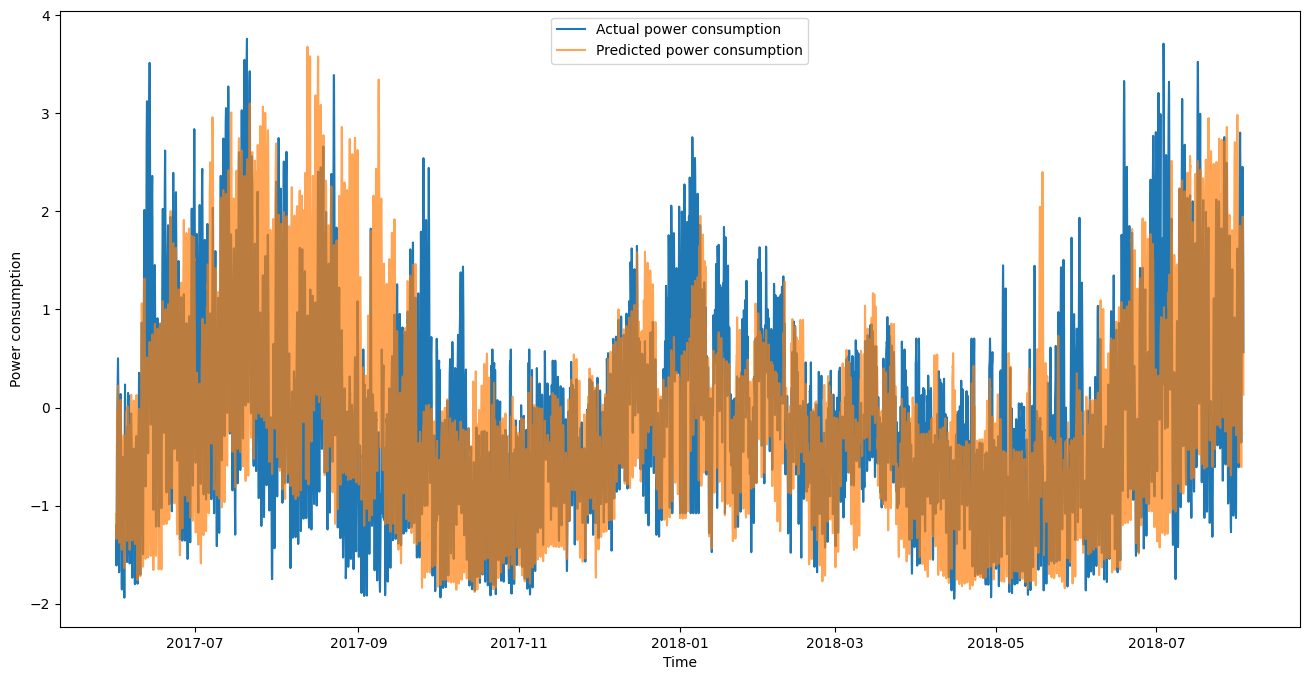

In [40]:
plot_predictions(test["Power_Demand"], test["Predicted demand"])

### 3- Neural Network LSTM :

In this part we will try to use neural networks to make the prediction, since future power consumption is significantly correlated with the past consumption, we will use the recurrent networks to take advantage of that and we will specificaly focus on the Long Short-Term Memory networks (LSTMs).

To train the LSTM network for our prediction we need to transform the power consumption data into a windowed structure. Each window will encompass a sequence of power consumption data, typically spanning 20 consecutive hours. The target for prediction will be the value immediately following the window, which corresponds to the 21st hour in our example.

In [41]:
def create_window_data(data, window_len, split_index):
    X = []
    Y = []
    for i in range(window_len, len(data)):
        X.append(data[i - window_len: i])
        Y.append(data[i])

    X_train = np.array(X[: split_index])
    y_train = np.array(Y[: split_index])
    X_test = np.array(X[split_index:])
    y_test = np.array(Y[split_index:])

    X_train = np.reshape(X_train, (X_train.shape[0], window_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], window_len, 1))

    return [X_train, y_train, X_test, y_test]

In [42]:
window_len = 20
split_index = list(data.index.astype("str")).index(split_date)
X_train, Y_train, X_test, Y_test = create_window_data(data["Power_Demand"], window_len, split_index)

In [43]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(LSTM(256, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(256, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(128, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [44]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, Y_train, epochs=30, batch_size=512, verbose=0)

<Axes: >

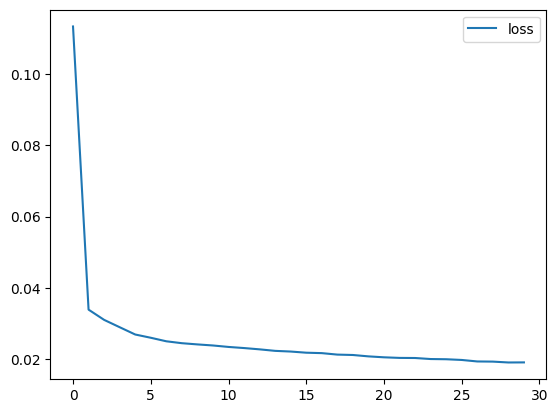

In [45]:
results = pd.DataFrame(lstm_model.history.history)
results.plot()

In [46]:
lstm_predictions = lstm_model.predict(X_test)
get_prediction_errors(Y_test, lstm_predictions)

321/321 [==============================] - 2s 4ms/step
R2 score: 0.9789906037818765
MAE: 0.06287629479090279
MSE: 0.02147540463448406
RMSE: 0.14654488948606859
MAPE: 773.2087680520483


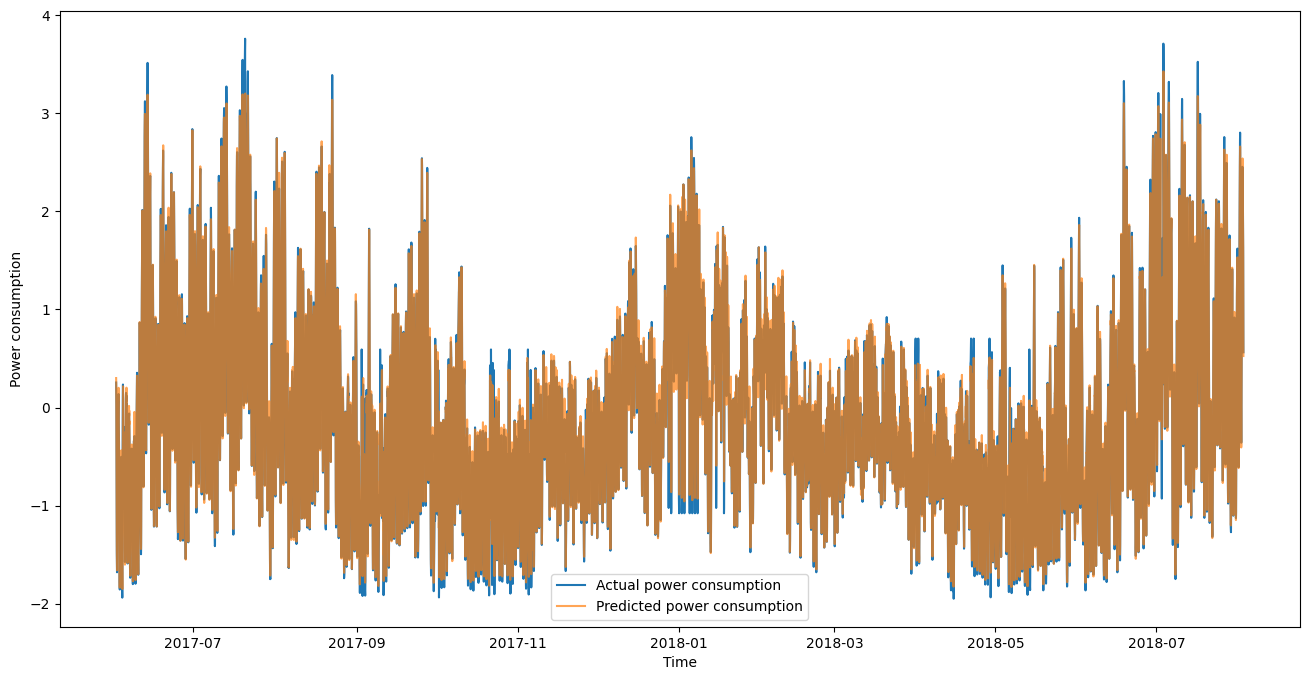

In [47]:
y_index = data.index[split_index+window_len:]
y_true = pd.DataFrame(Y_test, index=y_index)
y_pred = pd.DataFrame(lstm_predictions, index=y_index)
plot_predictions(y_true, y_pred)

## Future 7 day prediction

Using the trained models we will try to predict the next 7 days power consumption (without having the real consumption data to compare with).

In [48]:
def create_future_days_data(start_date, period):
    date_range = pd.date_range(start=start_date, periods=period, freq='h')
    future_days = pd.DataFrame({'Date': date_range})
    future_days.index = future_days["Date"]
    future_days['hour'] = future_days.index.hour
    future_days['dayofweek'] = future_days.index.dayofweek
    future_days['dayofmonth'] = future_days.index.day
    future_days['dayofyear'] = future_days.index.dayofyear
    future_days['quarter'] = future_days.index.quarter
    future_days['month'] = future_days.index.month
    future_days['year'] = future_days.index.year
    future_days['weekofyear'] = future_days.index.isocalendar().week.astype("int")
    future_days = future_days.drop(["Date"], axis=1)

    future_days = future_days[['hour','dayofweek','dayofmonth', 'dayofyear',
                               'quarter','month','year','weekofyear']]
    return future_days

In [49]:
start_date = '2018-08-03 00:00:00'
period = 7 * 24 # 7 days

### 1- XGBoost :

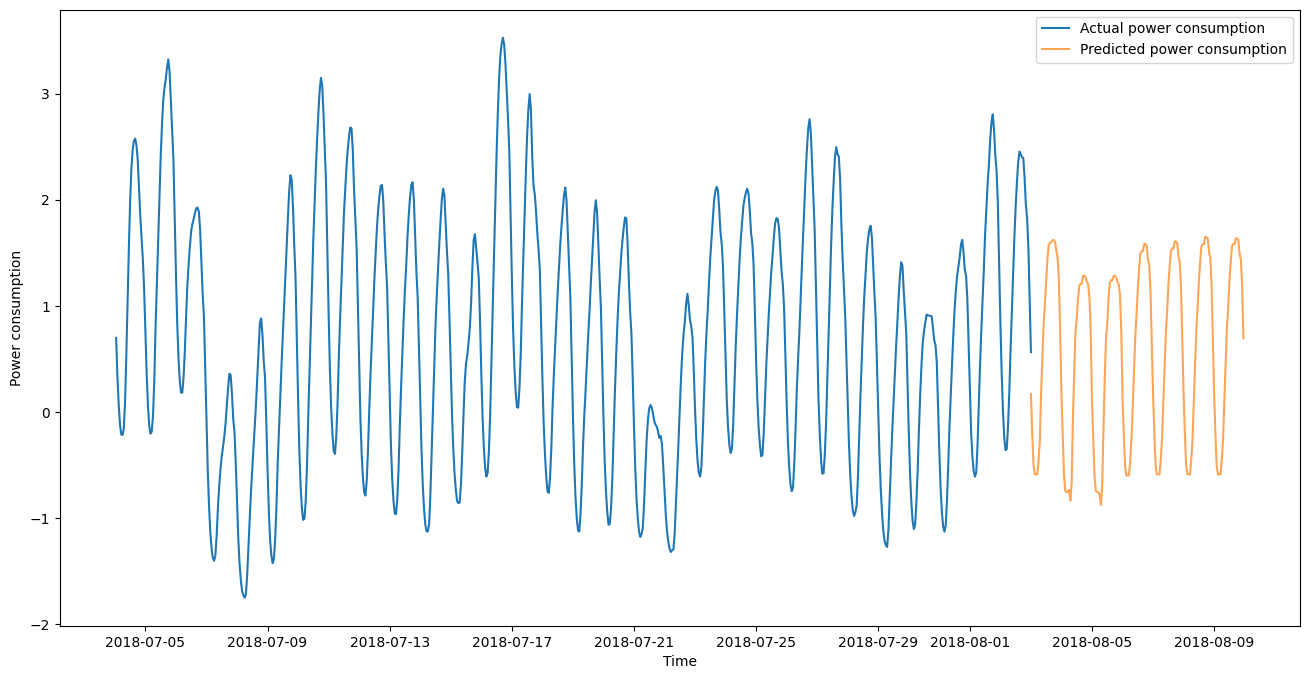

In [50]:
future_df = create_future_days_data(start_date, period)
future_prediction = reg.predict(future_df)
future_df["Power_Demand"] = future_prediction
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

### 2- Random Forest Regressor :

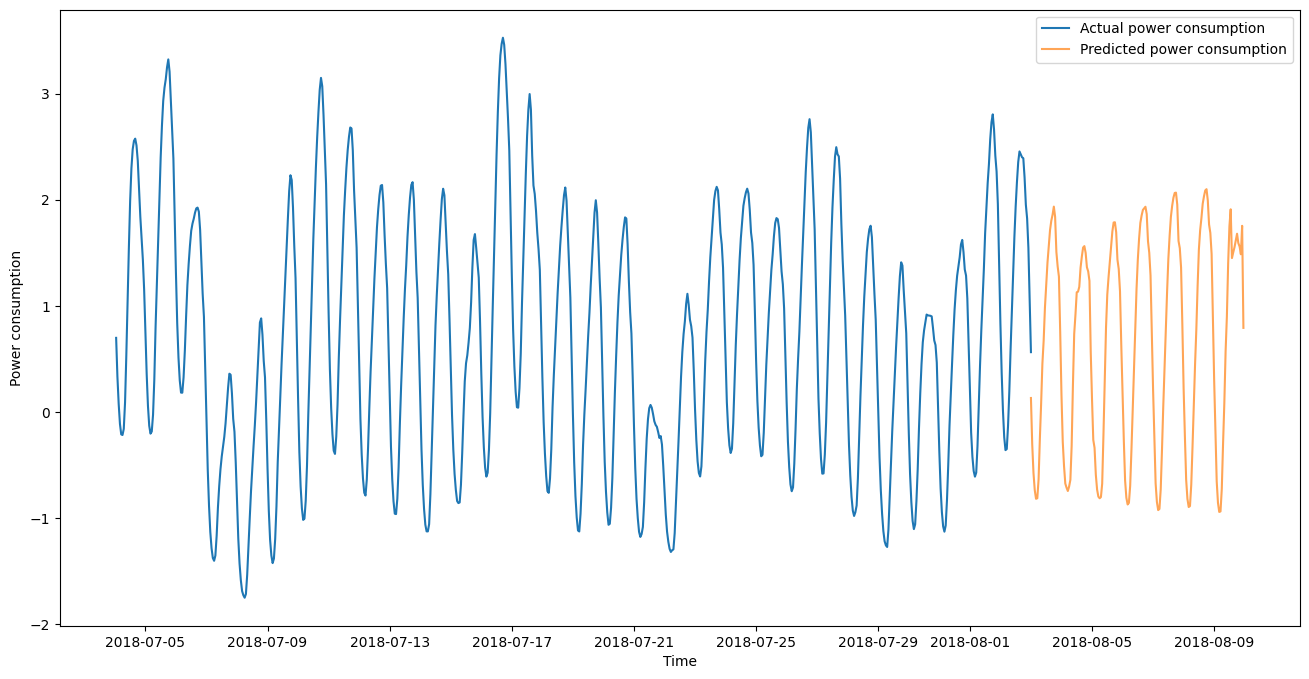

In [51]:
future_df = create_future_days_data(start_date, period)
future_prediction = rf.predict(future_df)
future_df["Power_Demand"] = future_prediction
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

### 3- LSTM :

In [54]:
lstm_future_days = np.array(data["Power_Demand"][-window_len:])

for i in range(168):
    x = np.reshape(lstm_future_days[i: i+window_len], (1, window_len, 1))
    predicted = lstm_model.predict(x, verbose=0)
    lstm_future_days = np.append(lstm_future_days, predicted)

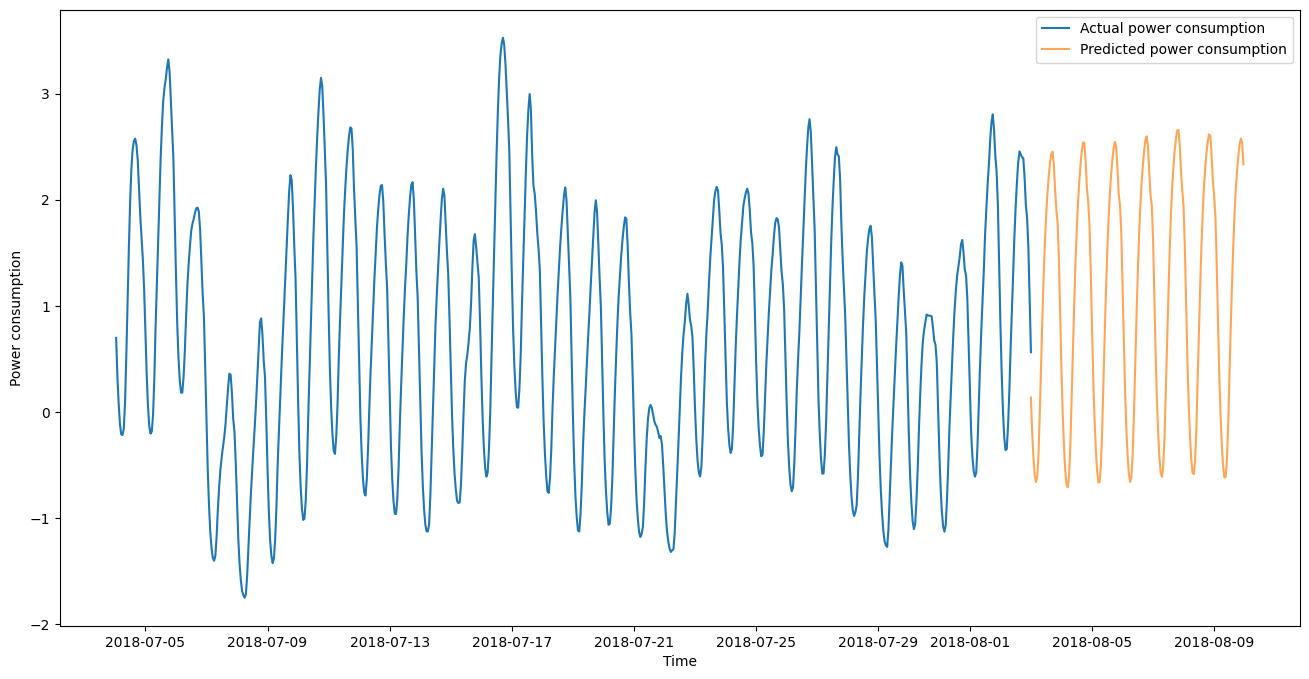

In [55]:
future_df = create_future_days_data(start_date, period)
future_df["Power_Demand"] = lstm_future_days[window_len:]
plot_predictions(y_test.iloc[-24*30:], future_df["Power_Demand"])

What do these results and plots tell us ?

* The LSTM model outperforms the XGBoost and Random Forest models in terms of accuracy metrics, a fact evident in the power consumption plots.

* When it comes to predicting power consumption for the next seven days, the LSTM model exhibits less favorable outcomes, with its predicted values appearing to stabilize around a constant value. This phenomenon can be attributed to the model's reliance on its own predictions to generate new forecasts.

* While the XGBoost and Random Forest models provide somewhat reasonable predictions for the next seven days (though not flawless), both exhibit results that follow a sinusoidal pattern, which deviates from the actual power consumption trend.

## Conculsion

For this power consumption forecast task, we tried to build three prediction models and after exploring the data and going through all the models training and testing steps, we have arrived at the following key findings :

1- LSTM models demonstrated superior accuracy in their predictions. However, they fell short in providing robust forecasts for future consumption trends.

2- On the contrary, the two machine learning models yielded subpar accuracy results but displayed a more reasonable ability to predict power consumption for the upcoming seven days.

3- It is worth noting that the results obtained in this study can be further enhanced by fine-tuning the models' hyperparameters. Nonetheless, to create an exceptionally accurate power consumption forecasting model, the incorporation of additional input features, such as weather data, will be essential.